In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from spectral_metric.estimator import CumulativeGradientEstimator
from spectral_metric.visualize import make_graph

In [3]:
# Lectura de dataset

data_dir = ('CIFAR-10 dos clases')
data_dir = pathlib.Path(data_dir)

# Lectura de la carpeta train
data_dir_train = ('CIFAR-10 dos clases')
data_dir_train = pathlib.Path(data_dir_train)

image_count_train = len(list(data_dir_train.glob('*/*.png')))  # Cuenta la cantidad de imagenes de train

print(f"Cantidad de imagenes de train: {image_count_train}")

Cantidad de imagenes de train: 10000


In [4]:
# Dimensiones de imagen y tamaño de batch
img_height = 32
img_width = 32
#batch_size = len(list(data_dir.glob('*/*.png'))) # leer todas las imágenes al tiempo
batch_size = image_count_train

In [5]:
import tensorflow as tf
import pathlib

# Data splitting (entrenamiento y validación)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")

Número de clases: 2
Los nombres de las clases son: ['cat', 'cat_c_defocus_blur']


In [7]:
for images, labels0 in train_ds.take(1):  # only take first element of dataset
    x_train = images.numpy()
    y_train = labels0.numpy()

x_train /= 255.0  # Scale the features to the [0, 1] range
#x_train = x_train.reshape(len(x_train), 1, 256, 256)  # reshape into [N, C, H, W] for PyTorch
print(x_train.shape)

(10000, 32, 32, 3)


c:\Users\Cesar\Desktop\Proyecto-CSG\1 - prueba de CSG\Pruebas en distintos datasets\spectral_metric\visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
c:\Users\Cesar\Desktop\Proyecto-CSG\1 - prueba de CSG\Pruebas en distintos datasets\spectral_metric\visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


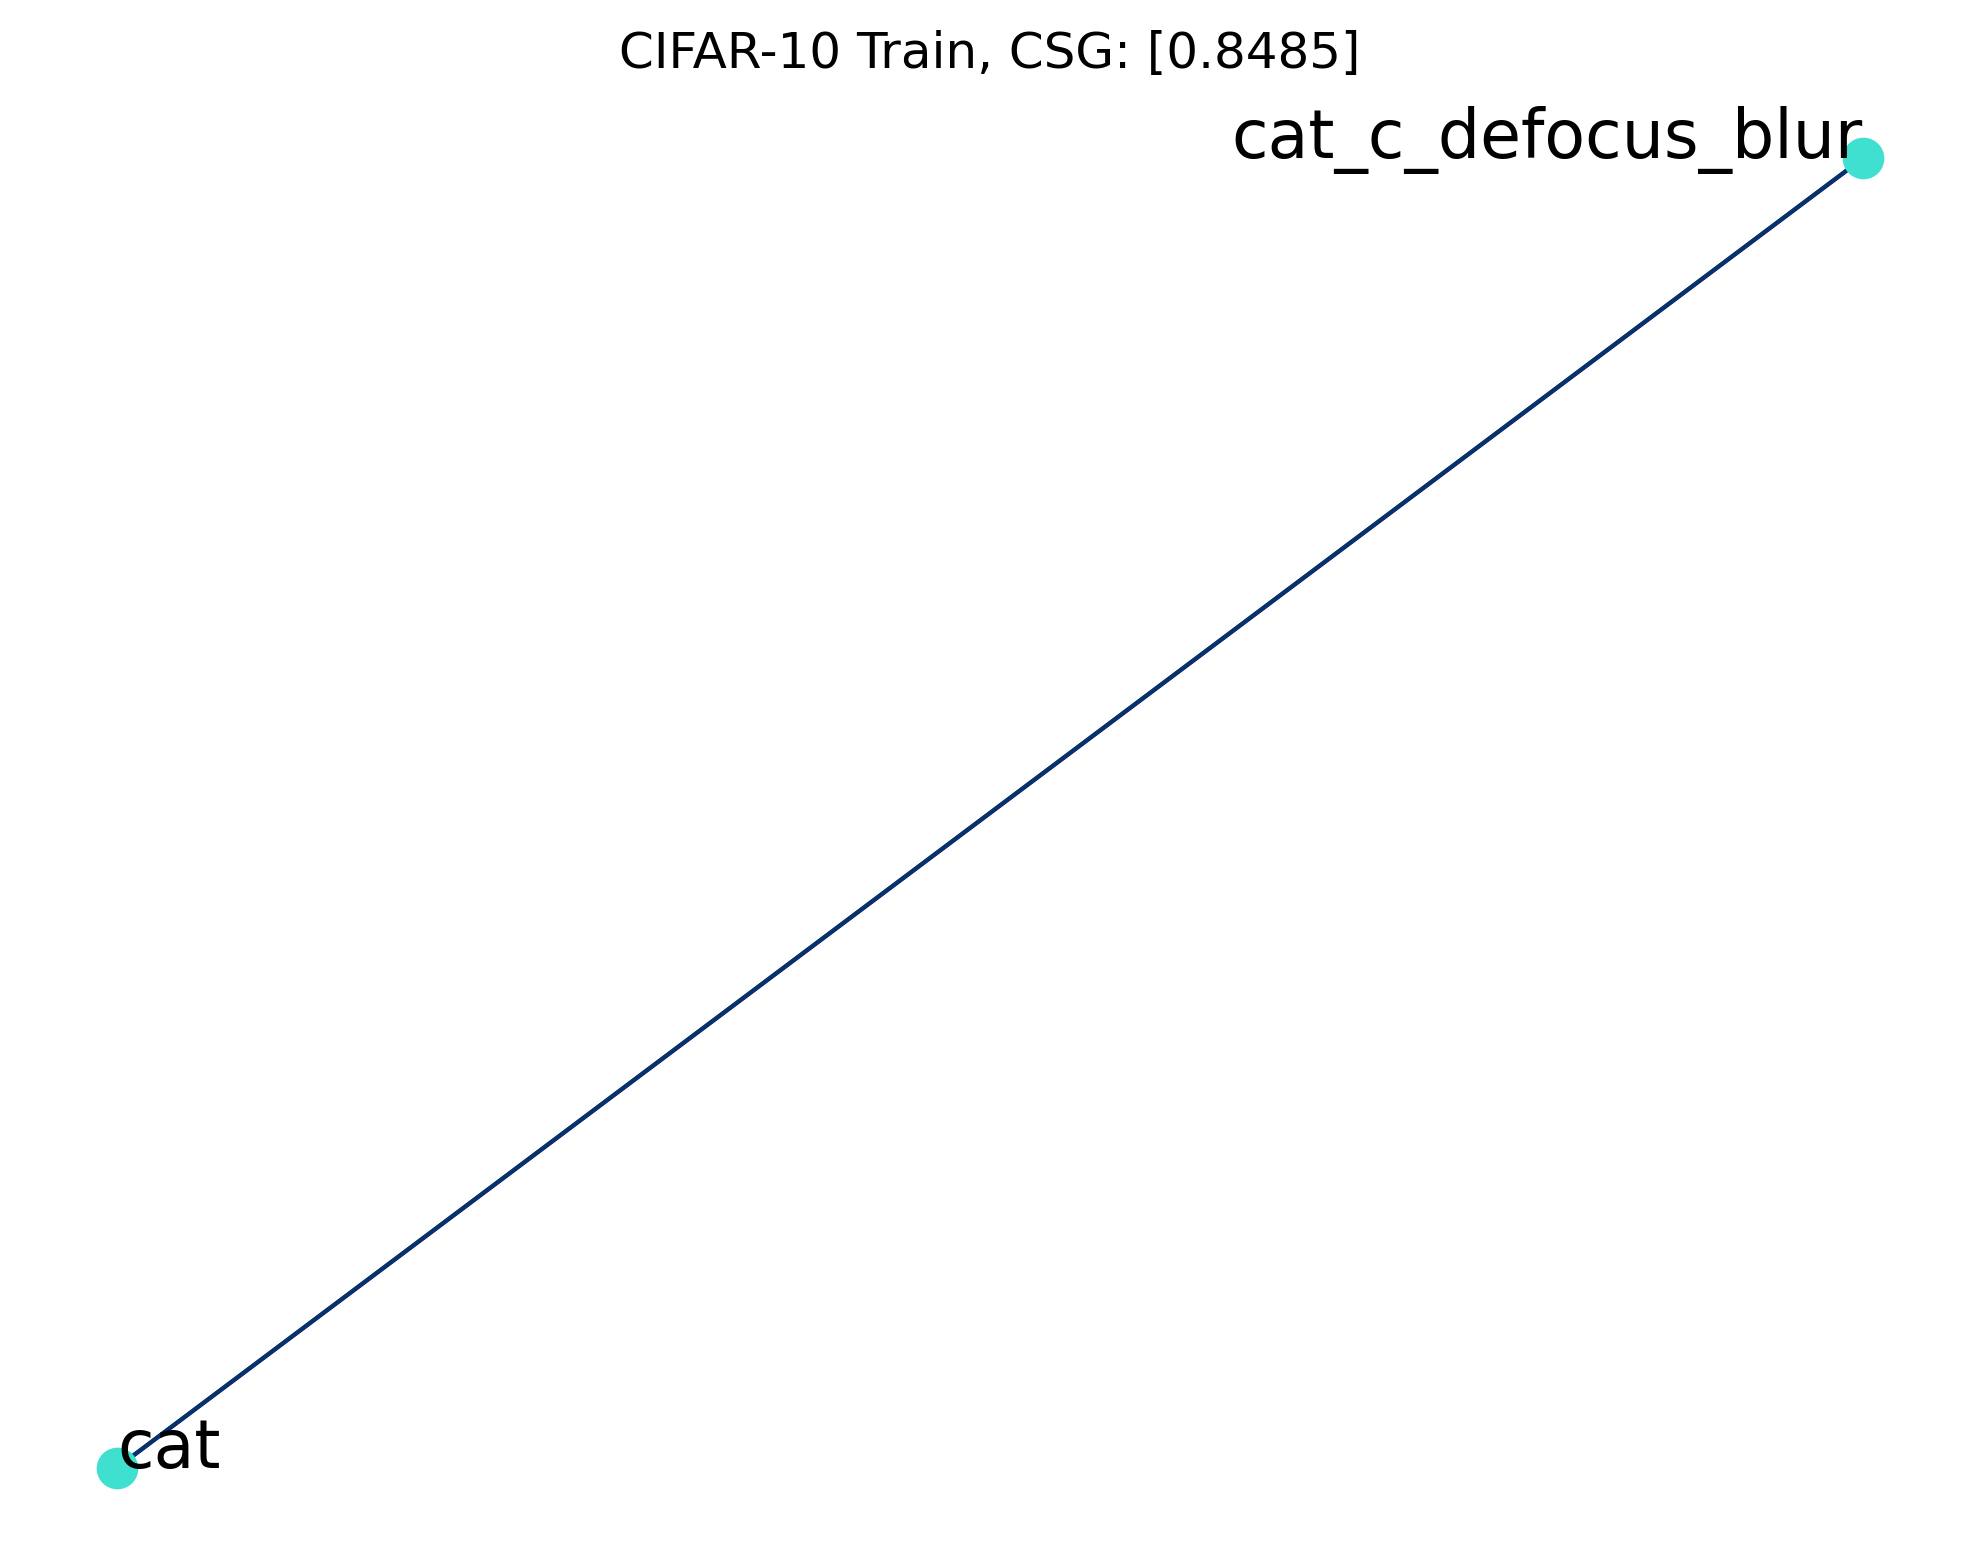

In [8]:
# CIFAR-10 TRAIN SET
X = x_train.reshape( (x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3]))
y = y_train.reshape(y_train.shape[0],)

estimator = CumulativeGradientEstimator(M_sample=1000, k_nearest=10)
estimator.fit(data=X, target=y)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="CIFAR-10 Train, CSG: "+str(csg), classes=class_names)

In [9]:
# Ordena los pares de clases en orden de similitud ascendente (menos similar primero)
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))
pairs = [(i,j) for i,j in pairs if i != j]

least_similar_pair = pairs[0]
i, j = least_similar_pair  # Pares de clases menos similares

print("Least similar pairs")
lst = []
for idx, (i,j) in enumerate(pairs[::2][:1]):
    lst.append({"Intent pair" : f"{class_names[i]} <> {class_names[j]}", "Similarity": estimator.W[i,j]})
print(pd.DataFrame(lst))

Least similar pairs
                 Intent pair  Similarity
0  cat <> cat_c_defocus_blur      0.8485


In [10]:
class_i_samples = X[y == i]
class_j_samples = X[y == j]

In [11]:
from scipy.spatial.distance import cdist

# Calcular la matriz de distancias entre las muestras de la clase i y la clase j
dist_matrix_ij = cdist(class_i_samples, class_j_samples)
# Encontrar el índice de las muestras menos similares (la mayor distancia)
max_dist_idx_ij = np.unravel_index(np.argmax(dist_matrix_ij), dist_matrix_ij.shape)

# Muestra de la clase i menos similar a las muestras de la clase j
least_similar_i_to_j = class_i_samples[max_dist_idx_ij[0]]
# Muestra de la clase j menos similar a las muestras de la clase i
least_similar_j_to_i = class_j_samples[max_dist_idx_ij[1]]

In [12]:
# Obtener los nombres de archivo correspondientes
filenames = [f.name for f in data_dir_train.glob('*/*.png')]
class_i_indices = np.where(y == i)[0]
class_j_indices = np.where(y == j)[0]

least_similar_i_to_j_filename = filenames[class_i_indices[max_dist_idx_ij[0]]]
least_similar_j_to_i_filename = filenames[class_j_indices[max_dist_idx_ij[1]]]

In [13]:
# Calcular la distancia de similitud entre las muestras seleccionadas
similarity_value = np.linalg.norm(least_similar_i_to_j - least_similar_j_to_i)

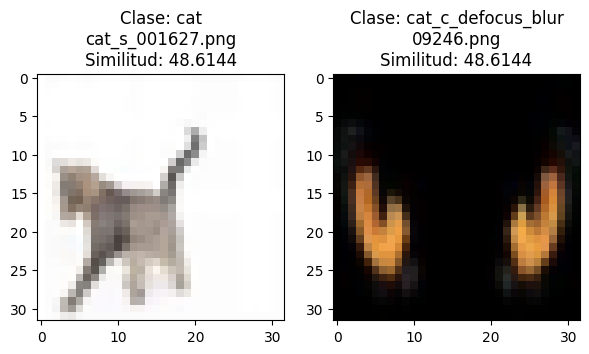

In [14]:
# Visualizar las muestras y la información
least_similar_i_to_j_img = least_similar_i_to_j.reshape(img_height, img_width, 3)
least_similar_j_to_i_img = least_similar_j_to_i.reshape(img_height, img_width, 3)

fig, axs = plt.subplots(1, 2, figsize=(7, 5))
axs[0].imshow(least_similar_i_to_j_img)
axs[0].set_title(f'Clase: {class_names[i]}\n{least_similar_i_to_j_filename}\nSimilitud: {similarity_value:.4f}')
axs[1].imshow(least_similar_j_to_i_img)
axs[1].set_title(f'Clase: {class_names[j]}\n{least_similar_j_to_i_filename}\nSimilitud: {similarity_value:.4f}')
# Entre mayor sea el valor de similitud significa que son menos similares (mas lejanas)
plt.show()

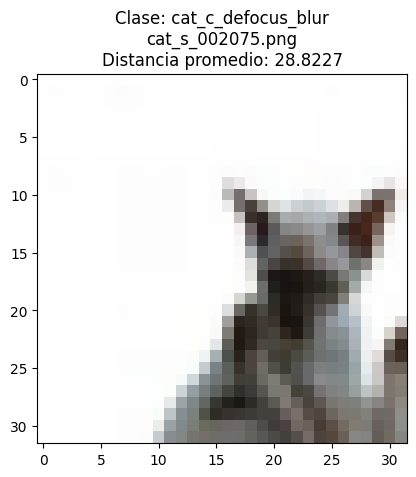

In [15]:
# Obtener el índice de la clase 'cat_c_defocus_blur'
i = class_names.index('cat_c_defocus_blur')

# Obtener las muestras de la clase 'cat_c_defocus_blur'
class_i_samples = X[y == i]

# Calcular las distancias entre las muestras de la clase 'cat_c_defocus_blur' y todas las demás muestras
dist_matrix_i = cdist(class_i_samples, X)

# Calcular la distancia promedio de cada muestra de la clase 'cat_c_defocus_blur' a las muestras de las otras clases
avg_dists_i = dist_matrix_i.mean(axis=1)

# Encontrar el índice de la muestra de la clase 'cat_c_defocus_blur' que tiene la mayor distancia promedio a las muestras de las otras clases
max_dist_idx_i = np.argmax(avg_dists_i)

# Obtener la muestra menos similar y su nombre de archivo correspondiente
least_similar_i = class_i_samples[max_dist_idx_i]
least_similar_i_filename = filenames[class_i_indices[max_dist_idx_i]]

# Visualizar la muestra menos similar
least_similar_i_img = least_similar_i.reshape(img_height, img_width, 3)
plt.imshow(least_similar_i_img)
plt.title(f'Clase: {class_names[i]}\n{least_similar_i_filename}\nDistancia promedio: {avg_dists_i[max_dist_idx_i]:.4f}')
plt.show()


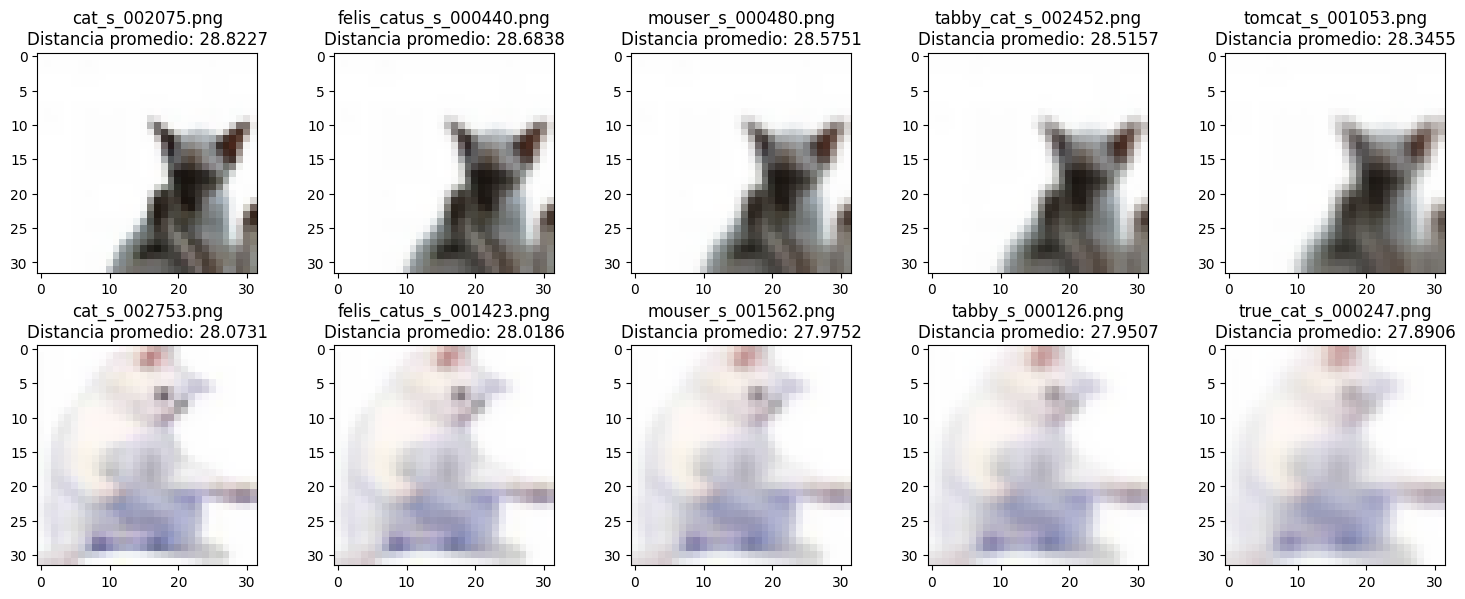

In [16]:
"""
# Obtener el índice de la clase 'cat_c_defocus_blur'
i = class_names.index('cat_c_defocus_blur')

# Obtener las muestras de la clase 'cat_c_defocus_blur'
class_i_samples = X[y == i]

# Calcular las distancias entre las muestras de la clase 'cat_c_defocus_blur' y todas las demás muestras
dist_matrix_i = cdist(class_i_samples, X)

# Calcular la distancia promedio de cada muestra de la clase 'cat_c_defocus_blur' a las muestras de las otras clases
avg_dists_i = dist_matrix_i.mean(axis=1)

# Ordenar las distancias promedio en orden descendente y obtener los índices
sorted_dist_idxs = np.argsort(avg_dists_i)[::-1]

# Seleccionar las 10 muestras menos similares y sus nombres de archivo correspondientes
least_similar_samples = class_i_samples[sorted_dist_idxs[:10]]
least_similar_filenames = [filenames[class_i_indices[idx]] for idx in sorted_dist_idxs[:10]]

# Visualizar las 10 muestras menos similares
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, sample, filename, dist in zip(axs.ravel(), least_similar_samples, least_similar_filenames, avg_dists_i[sorted_dist_idxs[:10]]):
    img = sample.reshape(img_height, img_width, 3)
    ax.imshow(img)
    ax.set_title(f'{filename}\nDistancia promedio: {dist:.4f}')
plt.tight_layout()
plt.show()
"""


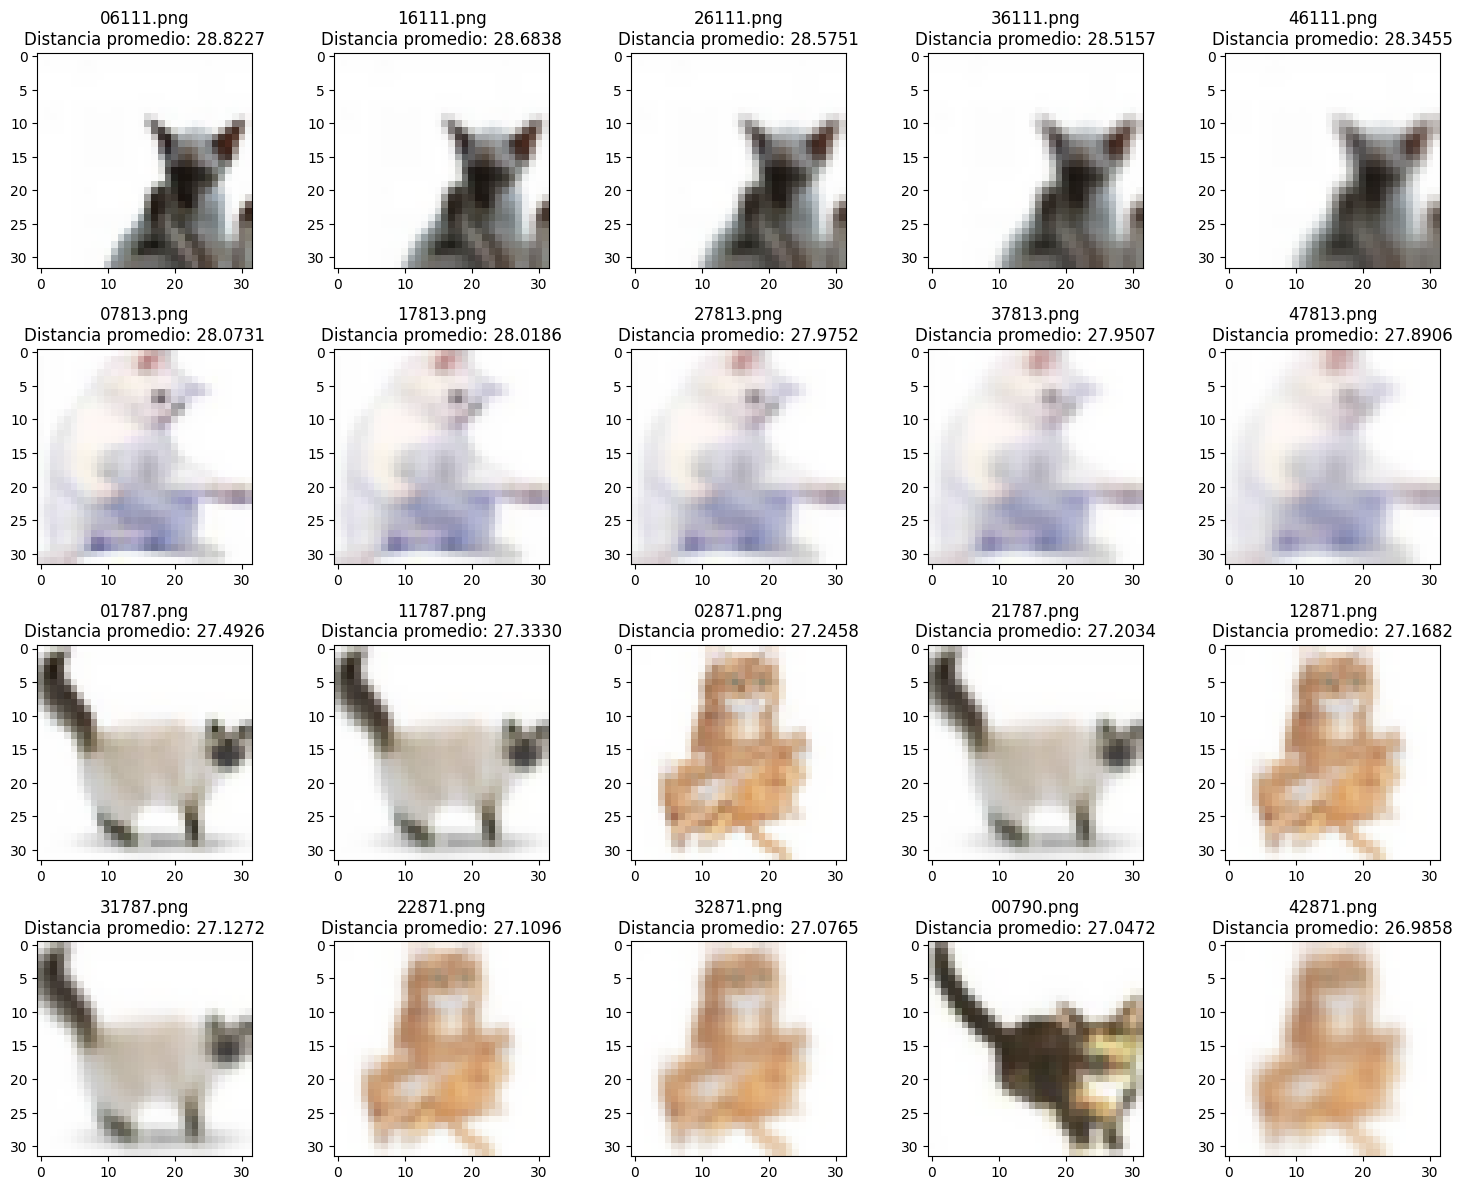

In [23]:
# Obtener los índices de las muestras de la clase 'cat_c_defocus_blur' en el conjunto de datos original
class_i_indices = np.where(y == i)[0]

# Obtener los nombres de archivo correspondientes a las muestras de la clase 'cat_c_defocus_blur'
class_i_filenames = [filenames[idx] for idx in class_i_indices]

# Ordenar las distancias promedio en orden descendente y obtener los índices
sorted_dist_idxs = np.argsort(avg_dists_i)[::-1]

# Seleccionar las 10 muestras menos similares y sus nombres de archivo correspondientes
least_similar_samples = class_i_samples[sorted_dist_idxs[:20]]
least_similar_filenames = [class_i_filenames[idx] for idx in sorted_dist_idxs[:20]]

# Visualizar las 10 muestras menos similares
fig, axs = plt.subplots(4, 5, figsize=(15, 12))
for ax, sample, filename, dist in zip(axs.ravel(), least_similar_samples, least_similar_filenames, avg_dists_i[sorted_dist_idxs[:20]]):
    img = sample.reshape(img_height, img_width, 3)
    ax.imshow(img)
    ax.set_title(f'{filename}\nDistancia promedio: {dist:.4f}')
plt.tight_layout()
plt.show()


In [21]:
from scipy.spatial import distance
import numpy as np

# X es el conjunto de datos y y son las etiquetas de clase
# i es la clase de interés

# Obtén las muestras de la clase de interés
samples_class_i = X[y == i]

# Obtén las muestras de todas las demás clases
samples_other_classes = X[y != i]

# Calcula la matriz de distancias entre las muestras de la clase de interés y todas las demás muestras
dist_matrix = distance.cdist(samples_class_i, samples_other_classes)

# Calcula la distancia promedio
avg_distance = np.mean(dist_matrix)

print(f"La distancia promedio entre las muestras de la clase {i} y todas las demás muestras es {avg_distance}")


La distancia promedio entre las muestras de la clase 1 y todas las demás muestras es 19.00917480031006


In [25]:
from scipy.spatial import distance
import numpy as np

# Supongamos que X es tu conjunto de datos y y son las etiquetas de clase
# y que class_i es la clase de interés

# Obtén las muestras de la clase de interés
samples_class_i = X[y == i]

# Calcular la matriz de distancias entre las muestras de la clase de interés
dist_matrix_i = distance.cdist(samples_class_i, samples_class_i)

# Calcular la distancia promedio de cada muestra de la clase de interés a las otras muestras de la misma clase
avg_dists_i = dist_matrix_i.mean(axis=1)

print(f"La distancia promedio entre las muestras de la clase {i} y las demás muestras de la misma clase es {np.mean(avg_dists_i)}")


La distancia promedio entre las muestras de la clase 1 y las demás muestras de la misma clase es 18.51641010115538


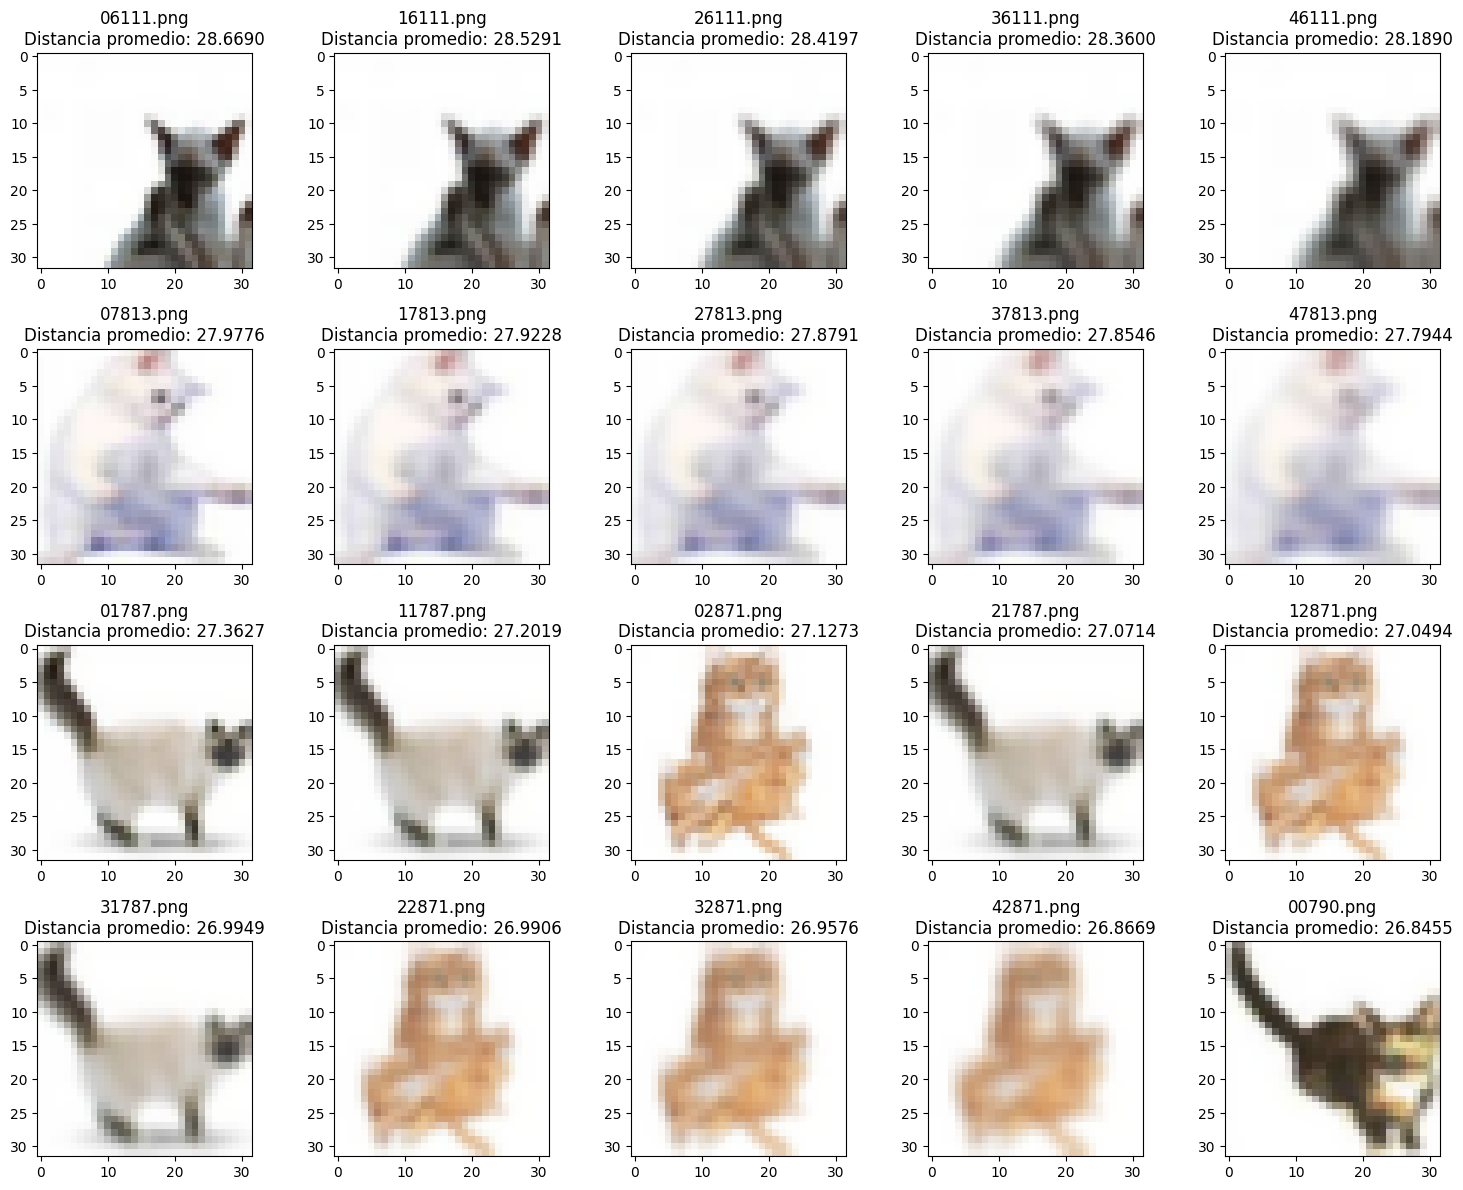

In [26]:
# Calcular la matriz de distancias entre las muestras de la clase de interés
dist_matrix_i = distance.cdist(samples_class_i, samples_class_i)

# Calcular la distancia promedio de cada muestra de la clase de interés a las otras muestras de la misma clase
avg_dists_i = dist_matrix_i.mean(axis=1)

# Ordenar las distancias promedio en orden descendente y obtener los índices
sorted_dist_idxs = np.argsort(avg_dists_i)[::-1]

# Seleccionar las 20 muestras con la mayor distancia promedio y sus nombres de archivo correspondientes
most_distant_samples = samples_class_i[sorted_dist_idxs[:20]]
most_distant_filenames = [class_i_filenames[idx] for idx in sorted_dist_idxs[:20]]

# Visualizar las 20 muestras con la mayor distancia promedio
fig, axs = plt.subplots(4, 5, figsize=(15, 12))
for ax, sample, filename, dist in zip(axs.ravel(), most_distant_samples, most_distant_filenames, avg_dists_i[sorted_dist_idxs[:20]]):
    img = sample.reshape(img_height, img_width, 3)
    ax.imshow(img)
    ax.set_title(f'{filename}\nDistancia promedio: {dist:.4f}')
plt.tight_layout()
plt.show()
